In [ ]:
# %% [markdown]
# ## Merging Tables for PCA and Classification Prep

In [ ]:
# %% [markdown]
# ### 1. Imports & Settings

# %%
# Standard libs
import pandas as pd
import numpy as np
from pathlib import Path

# Modeling & utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (StratifiedKFold, GridSearchCV,
                                     cross_val_score, permutation_test_score)
from sklearn.feature_selection import RFECV
from sklearn.cluster import FeatureAgglomeration
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# %% [markdown]
# ### 2. Helper Functions

# %%
def load_dataset(path, **kwargs):
    """Read CSV, raising a clear error if it fails."""
    try:
        return pd.read_csv(path, **kwargs)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        raise

def merge_with_priority(left: pd.DataFrame, right: pd.DataFrame, on: str, how: str="left") -> pd.DataFrame:
    """Left-merge right into left, coalescing overlapping columns (prefer left values)."""
    merged = left.merge(right, on=on, how=how, suffixes=("_left","_right"))
    # find overlaps
    overlap = {
        col[:-5] for col in merged if col.endswith("_left")
    }.intersection({
        col[:-6] for col in merged if col.endswith("_right")
    })
    for base in overlap:
        l, r = base + "_left", base + "_right"
        merged[base] = merged[l].combine_first(merged[r])
        merged.drop([l, r], axis=1, inplace=True)
    return merged

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score

def reverse_engineer_rules_from_df(df: pd.DataFrame,
                                   diet_vars: list,
                                   combined_vars: list,
                                   target_col: str,
                                   display_rules: bool = True,
                                   display_mismatches: bool = True) -> DecisionTreeClassifier:
    """
    1. Drops NA in target_col.
    2. Trains a fully-grown tree (no depth limit) on diet_vars+combined_vars → target_col.
    3. Prints rules (if display_rules).
    4. Prints perfect-fit accuracy and up to 10 mismatches (if display_mismatches).
    Returns the fitted DecisionTreeClassifier.
    """
    df2 = df.dropna(subset=[target_col])
    X = df2[diet_vars + combined_vars]
    y = df2[target_col]

    # train overfit tree
    dt = DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=0
    )
    dt.fit(X, y)

    # rules
    if display_rules:
        print("\nLearned rules:\n")
        print(export_text(dt, feature_names=diet_vars + combined_vars))

    # accuracy & mismatches
    y_pred = dt.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"\nPerfect-fit accuracy: {acc:.3f}")
    if display_mismatches:
        comp = pd.DataFrame({"actual": y, "pred": y_pred})
        comp["match"] = comp.actual == comp.pred
        fails = comp[~comp.match]
        print(f"\nMismatches: {len(fails)} (showing up to 10)")
        display(fails.head(10))

    return dt


def apply_tree_to_master(master_df: pd.DataFrame,
                         dt: DecisionTreeClassifier,
                         diet_vars: list,
                         combined_vars: list,
                         target_col: str = None) -> pd.DataFrame:
    """
    1. Recomputes combined_vars on master_df.
    2. Predicts with dt into column 'Predicted_Diet_Class'.
    3. Prints predicted class counts.
    4. If target_col provided and exists, prints actual counts & accuracy.
    Returns master_df with new column.
    """
    df = master_df.copy()
    # recompute combined columns
    df["Diet.VertTerrestrial"] = df["Diet.Vend"] + df["Diet.Vect"] + df["Diet.Vunk"]
    df["Diet.VertAll"]         = df["Diet.VertTerrestrial"] + df["Diet.Vfish"]
    df["Diet.AnimalsAll"]      = df["Diet.VertAll"] + df["Diet.Inv"]
    df["Diet.PlantHighSugar"]  = df["Diet.Fruit"] + df["Diet.Nect"]
    df["Diet.PlantLowSugar"]   = df["Diet.Seed"] + df["Diet.PlantO"]
    df["Diet.PlantAll"]        = df["Diet.PlantHighSugar"] + df["Diet.PlantLowSugar"]

    # predict
    X_all = df[diet_vars + combined_vars]
    df["Diet_Class"] = dt.predict(X_all)
    print("Predicted distribution:")
    print(df["Diet_Class"].value_counts(), "\n")

    # optional evaluation
    if target_col and target_col in df.columns:
        mask = df[target_col].notna()
        actual = df.loc[mask, target_col]
        pred   = df.loc[mask, "Diet_Class"]
        acc = accuracy_score(actual, pred)
        print("Actual distribution:")
        print(actual.value_counts(), "\n")
        print(f"Accuracy on labeled subset: {acc:.3f}\n")

    return df


def clean_and_reorder(df: pd.DataFrame, cols_to_drop: list) -> pd.DataFrame:
    """Drop cols, then reorder by dtype groups (num, bool, dt, cat, obj, other)."""
    df = df.drop(columns=cols_to_drop, errors="ignore")
    obj = df.select_dtypes("object").columns.tolist()
    num = df.select_dtypes("number").columns.tolist()
    bl = df.select_dtypes("bool").columns.tolist()
    dt = df.select_dtypes(["datetime","datetime64"]).columns.tolist()
    cat = df.select_dtypes("category").columns.tolist()
    oth = [c for c in df.columns if c not in num+bl+dt+cat+obj]
    order = cat+oth+obj+num+bl+dt
    print(f"Columns by group:\n  Numeric: {num}\n  Bool:    {bl}\n  Date:    {dt}\n  Cat:     {cat}\n  Obj:     {obj}\n  Other:   {oth}")
    return df[order]

In [ ]:
# %% [markdown]
# ### 3. Load & Merge Sources

# %%
# load
combine_reported = load_dataset("data/trait_data_reported.csv").rename(columns={"iucn2020_binomial":"scientific"})
combine_imputed = load_dataset("data/trait_data_imputed.csv")  # if used
Elton_full       = load_dataset("data/MamFuncDat.csv").rename(columns={"Scientific":"scientific"})
MammalDiet_2015  = load_dataset("data/MammalDIET_v1.0.txt.csv")
MammalDiet_2018  = load_dataset("data/mam12119-sup-0001-appendixs1.csv", skiprows=2).rename(columns={"Binomial":"scientific"})
Myhrvold         = load_dataset("data/Amniote_Database_Aug_2015.csv").assign(
                      scientific=lambda d: d.genus+" "+d.species)
Dietary_Guild    = load_dataset("data/Supplemental_data_1_diet_dataset.csv")
Validation_Data  = load_dataset("data/mergedData.csv").rename(columns={"ScientificNameFull":"scientific"})

# merge 2015/2018
MammalDiet_2015["scientific"] = MammalDiet_2015.Genus + " " + MammalDiet_2015.Species
MD = merge_with_priority(MammalDiet_2015, MammalDiet_2018, on="scientific", how="outer")

# drop suffix and null columns
MD = MD.loc[:, ~MD.columns.str.startswith("Unnamed:")].dropna(axis=1, how="all")
MD = MD.drop(columns=[c for c in ["TaxonID","TaxonomicNote","FillCode","DataSource","Bibliography"]
                      if c in MD.columns])

# build master
M1 = merge_with_priority(Elton_full, MD, on="scientific")
M2 = merge_with_priority(M1, combine_reported, on="scientific")
M3 = merge_with_priority(M2, Myhrvold, on="scientific")
Master_DatasetAll        = merge_with_priority(M3, Validation_Data, on="scientific")

In [ ]:
# %% [markdown]
# ### 5. Clean, Reorder & Impute Master_DatasetAll

# %%
cols_to_drop = [
    "TrophicLevel","MammalEater","Insectivore","Frugivore","Granivore","Folivore",
    "phylacine_binomial","class","subspecies","common_name","CommonName",
    "Meyer.Diet.Categorical","Meyer.Lab.Classification","Meyer.Lab.Classification.Clean",
    "Meyer.Lab.Classification.Compressed","MeyerTrophicLevel","DerekDietClassification70",
    "DerekDietClassification90","MSW3_ID"
]
# 1) Drop & reorder
Master_DatasetAll_clean = clean_and_reorder(Master_DatasetAll, cols_to_drop)

# 2) Keep only numeric + whitelisted object columns
object_whitelist = [
    "scientific","Order","Family","Genus","Species",
    "DerekDietClassification90InsVertivoreSorting",
    "foraging_stratum","biogeographical_realm","ZoonomiaName","ZoonomiaTip"
]
master_all_final = pd.concat([
    Master_DatasetAll_clean.select_dtypes(exclude="object"),
    Master_DatasetAll_clean[object_whitelist]
], axis=1)

# %%
# 1) find all numeric columns
num_cols = master_all_final.select_dtypes(include='number').columns

# 2) compute their maxima
max_vals = master_all_final[num_cols].max()

# 3) identify columns to remove (max == -999)
to_drop = max_vals[max_vals == -999].index.tolist()
print(f"Removing {len(to_drop)} columns with max == -999:\n", to_drop)

# 4) drop them
master_all_final.drop(columns=to_drop, inplace=True)

# 5) recompute numeric columns and maxima after drop
num_cols = master_all_final.select_dtypes(include='number').columns
max_vals = master_all_final[num_cols].max()

# 6) identify remaining columns with max ≤ 10
to_cat = max_vals[max_vals <= 10].index.tolist()

# 7) exclude these specific features from being turned into categorical
exclude_features = ["litters_per_year_n", "litters_or_clutches_per_y", "incubation_d"]
to_cat = [col for col in to_cat if col not in exclude_features]

print(f"Converting {len(to_cat)} small-range columns (max ≤ 10), excluding {exclude_features}:\n", to_cat)

# 8) convert to pandas Categorical dtype
master_all_final[to_cat] = master_all_final[to_cat].astype('category')

# 9) inspect their new dtypes
print(master_all_final[to_cat].dtypes)

# %% [markdown]
# ### 6a. Reclassify certain object columns as categorical

# %%
# List of object columns to convert
cat_cols = [
    "scientific",
    "Order",
    "Family",
    "Genus",
    "DerekDietClassification90InsVertivoreSorting",
    "foraging_stratum",
    "biogeographical_realm"
]

# Convert them to pandas Categorical dtype
master_all_final[cat_cols] = master_all_final[cat_cols].astype("category")

# Verify
print(master_all_final[cat_cols].dtypes)

# %% [markdown]
# ### 6b. Recompute combined diet variables on master_all_final

# %%
master_all_final["Diet.VertTerrestrial"] = (
    master_all_final["Diet.Vend"] 
    + master_all_final["Diet.Vect"] 
    + master_all_final["Diet.Vunk"]
)
master_all_final["Diet.VertAll"] = (
    master_all_final["Diet.VertTerrestrial"] 
    + master_all_final["Diet.Vfish"]
)
master_all_final["Diet.AnimalsAll"] = (
    master_all_final["Diet.VertAll"] 
    + master_all_final["Diet.Inv"]
)
master_all_final["Diet.PlantHighSugar"] = (
    master_all_final["Diet.Fruit"] 
    + master_all_final["Diet.Nect"]
)
master_all_final["Diet.PlantLowSugar"] = (
    master_all_final["Diet.Seed"] 
    + master_all_final["Diet.PlantO"]
)


# 1) Set threshold
threshold = 0.2

# 2) Build a boolean mask of missing or sentinel values
mask_missing = master_all_final.isna() | (master_all_final == -999.0)

# 3) Compute fraction missing per column
missing_frac = mask_missing.mean()

# 4) Identify columns to drop
cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()

# 5) Exclude the target column from being dropped
protected = "DerekDietClassification90InsVertivoreSorting"
cols_to_drop = [c for c in cols_to_drop if c != protected]

print(f"Dropping {len(cols_to_drop)} columns (excluding '{protected}'):\n", cols_to_drop)

# 6) Drop them from the DataFrame
master_all_final.drop(columns=cols_to_drop, inplace=True)

master_all_final = clean_and_reorder(master_all_final, cols_to_drop)

# %% [markdown]
# ### 7. Full describe() and save to CSV

# %%
import pandas as pd

# allow display of all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# describe all columns and transpose
summary_all = master_all_final.describe(include='all').T

# display in notebook
summary_all

# save to CSV for external viewing
summary_all.to_csv("data/Master_DatasetAll_summary.csv", index=True)


Columns by group:
  Numeric: ['Herptile', 'Mammal', 'Fruit', 'Nectar', 'Fish', 'Woody', 'Other', 'Animal', 'Plant', 'Herbaceous', 'Vertebrate', 'Invertebrate', 'Leaf', 'Seed', 'Bird', 'adult_mass_g', 'adult_brain_mass_g', 'adult_body_length_mm', 'adult_forearm_length_mm', 'max_longevity_d', 'maturity_d', 'age_first_reproduction_d', 'gestation_length_d', 'teat_number_n', 'litter_size_n', 'litters_per_year_n', 'interbirth_interval_d', 'neonate_mass_g', 'weaning_age_d', 'weaning_mass_g', 'generation_length_d', 'dispersal_km', 'density_n_km2', 'hibernation_torpor', 'fossoriality', 'home_range_km2', 'social_group_n', 'dphy_invertebrate', 'dphy_vertebrate', 'dphy_plant', 'det_inv', 'det_vend', 'det_vect', 'det_vfish', 'det_vunk', 'det_scav', 'det_fruit', 'det_nect', 'det_seed', 'det_plantother', 'det_diet_breadth_n', 'trophic_level', 'activity_cycle', 'freshwater', 'marine', 'terrestrial_non-volant', 'terrestrial_volant', 'upper_elevation_m', 'lower_elevation_m', 'altitude_breadth_m', 'islan

In [ ]:

# describe all columns and transpose
type_all = master_all_final.dtypes


# save to CSV for external viewing
type_all.to_csv("data/type_all.csv", index=True)

In [ ]:
# define your feature sets
diet_vars = ["Diet.Inv","Diet.Vend","Diet.Vect","Diet.Vfish","Diet.Vunk",
             "Diet.Scav","Diet.Fruit","Diet.Nect","Diet.Seed","Diet.PlantO"]
combined_vars = ["Diet.VertTerrestrial","Diet.VertAll","Diet.AnimalsAll",
                 "Diet.PlantHighSugar","Diet.PlantLowSugar","Diet.PlantAll"]
target = "DerekDietClassification90InsVertivoreSorting"

# 1) Reverse‐engineer rules on validation set
val_df = pd.read_csv("data/Master_DatasetValidation.csv")
dt = reverse_engineer_rules_from_df(val_df, diet_vars, combined_vars, target)

# 2) Apply that tree to the full master set
all_with_preds = apply_tree_to_master(master_all_final, dt, diet_vars, combined_vars, target)

# 3) Save out
all_with_preds.to_csv("data/Master_DatasetAll_with_predictions.csv", index=False)

# 3) Prepare for Genus‐based median imputation
feature_cols = all_with_preds.select_dtypes(include='number').columns.tolist()
df_clean = all_with_preds.copy()
df_clean[feature_cols] = df_clean[feature_cols].replace(-999.0, np.nan)

X_clean = df_clean[feature_cols]
numeric_cols = X_clean.columns.tolist()

# 4) Impute within each Genus
X_imputed = (
    pd.concat([df_clean[['Genus']], X_clean[numeric_cols]], axis=1)
      .groupby('Genus')[numeric_cols]
      .transform(lambda col: col.fillna(col.median()))
)

# 5) Global‐median fallback
for col in numeric_cols:
    if X_imputed[col].isna().any():
        global_med = X_clean[col].median()
        X_imputed[col].fillna(global_med, inplace=True)

# 6) Reassemble final DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=numeric_cols, index=df_clean.index)
master_all_final[numeric_cols] = X_imputed

# 7) Save out
master_all_final.to_csv("data/Master_DatasetAll_final.csv", index=False)
print("Saved cleaned & imputed Master_DatasetAll to data/Master_DatasetAll_final.csv")


Learned rules:

|--- Diet.PlantO <= 85.00
|   |--- Diet.Inv <= 85.00
|   |   |--- Diet.PlantAll <= 85.00
|   |   |   |--- Diet.AnimalsAll <= 85.00
|   |   |   |   |--- Diet.Inv <= 45.00
|   |   |   |   |   |--- Diet.PlantO <= 45.00
|   |   |   |   |   |   |--- Diet.Fruit <= 45.00
|   |   |   |   |   |   |   |--- Diet.Nect <= 50.00
|   |   |   |   |   |   |   |   |--- Diet.Seed <= 45.00
|   |   |   |   |   |   |   |   |   |--- Diet.Scav <= 55.00
|   |   |   |   |   |   |   |   |   |   |--- Diet.VertAll <= 70.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: O-Generalist
|   |   |   |   |   |   |   |   |   |   |--- Diet.VertAll >  70.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: O-For Examination
|   |   |   |   |   |   |   |   |   |--- Diet.Scav >  55.00
|   |   |   |   |   |   |   |   |   |   |--- Diet.Fruit <= 5.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: O-Scavenger
|   |   |   |   |   |   |   |   |   |   |--- Diet.Fruit >  5.00
|   |   |   |   |

,actual,pred,match
28,O-Generalist,H-All-plants-Eater,False
185,H-Nectarivore,H-High-sugar-plants-Eater,False
227,C-InsVertivore-Piscivore,C-InsVertivore-Mixed,False
272,O-Generalist,O-For Examination,False
374,C-Piscivore,C-InsVertivore-Piscivore,False


Predicted distribution:
Diet_Class
O-Generalist                       1273
C-Invertebrate-eater                920
O-For Examination                   918
H-All-plants-Eater                  778
H-Nonspecific-Herbivore             626
H-Low-sugar-plants-Eater            313
H-Frugivore                         180
C-InsVertivore-Insectivore          148
H-High-sugar-plants-Eater            99
C-InsVertivore-Mixed                 64
C-Endotherm-Carnivore                42
C-InsVertivore-Carnivore             30
C-Terrestrial-vertebrates-eater      27
C-InsVertivore-Piscivore              4
C-All-vertebrate-eater                4
O-Scavenger                           2
C-Piscivore                           2
C-Scavenger                           2
Name: count, dtype: int64 

Actual distribution:
DerekDietClassification90InsVertivoreSorting
H-Nonspecific-Herbivore            103
H-All-plants-Eater                  56
C-Invertebrate-eater                47
O-Generalist                      

/tmp/ipykernel_1297042/2114430184.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Genus')[numeric_cols]


Saved cleaned & imputed Master_DatasetAll to data/Master_DatasetAll_final.csv


/tmp/ipykernel_1297042/2114430184.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(global_med, inplace=True)
/tmp/ipykernel_1297042/2114430184.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [ ]:
# 1) Allow pandas to print every column in wide tables
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# 2) Describe every column, regardless of dtype
summary_all = Master_DatasetAll.describe(include='all')

# 3) (Optional) transpose so each feature is a row
summary_all = summary_all.T

# 4) Display
summary_all

summary_all.to_csv("data/Master_DatasetAll_summary.csv")


## 6. Manual PCA Implementation

Instead of using `sklearn.decomposition.PCA`, we’ll build PCA step-by-step:

1. Center the data (zero mean).  
2. Compute the covariance matrix.  
3. Perform an eigen‐decomposition.  
4. Sort eigenvalues/vectors.  
5. Compute explained-variance ratios.  
6. Project onto the top *k* principal components.


6.1. Prepare data for PCA

Max |mean| ≈ 1.4650365685775261e-16
Min/std ≈ 0.9999999999999998 / Max/std ≈ 1.0000000000000002


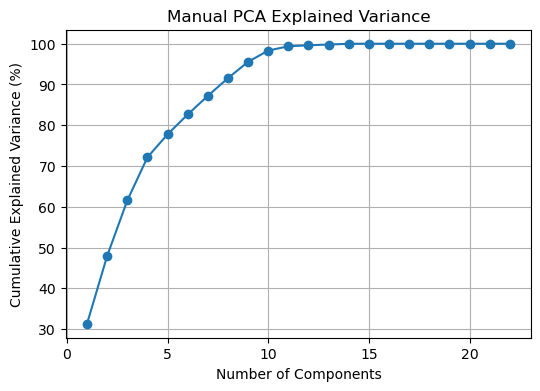

Using k = 8 components to reach ≥90% variance
        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8
0  3.108700 -2.422595  0.584996 -0.068976  0.731171  0.192102  0.042925 -0.190586
1  3.106093 -2.417594  0.613334 -0.078273  0.731246  0.191284  0.041120 -0.190881
2  3.101544 -2.408700  0.664951 -0.095571  0.731382  0.189532  0.037246 -0.191500
3 -0.424278 -0.495003 -0.011796  0.250456  0.036170  0.181971  0.307834 -0.067093
4  3.670097 -0.537904  0.353413  0.126756  0.255304  3.774769 -1.980939  2.571506
Top contributors to PC1: ['Diet.PlantAll', 'dphy_plant', 'Diet.AnimalsAll', 'Diet.Inv', 'dphy_invertebrate']
Top contributors to PC2: ['Diet.VertAll', 'Diet.VertTerrestrial', 'Diet.Vend', 'dphy_vertebrate', 'Diet.Inv']
Top contributors to PC3: ['adult_body_mass_g', 'adult_mass_g', 'BodyMass.Value', 'Diet.PlantHighSugar', 'Diet.Fruit']
Top contributors to PC4: ['Diet.PlantHighSugar', 'Diet.Fruit', 'Diet.PlantLowSugar', 'Diet.PlantO', 'Diet.Nect']
Top contribu

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- assume X_imputed (DataFrame) exists, after Genus‐median + sentinel→NaN impute

# 1. Verify imputation & scaling --------------------------------------------------

# convert to array
X_arr = X_imputed.values

# 1a) no more sentinels or NaNs
assert not np.any(X_arr == -999.0), "Sentinel -999 still present!"
assert not np.isnan(X_arr).any(), "NaNs remain in X_arr!"

# 1b) scale to zero‐mean/unit‐var
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_arr)

# verify
means = X_scaled.mean(axis=0)
stds  = X_scaled.std(axis=0, ddof=0)
print("Max |mean| ≈", np.max(np.abs(means)))
print("Min/std ≈", stds.min(), "/ Max/std ≈", stds.max())


# 2. Manual PCA eigendecomp ------------------------------------------------------

# center explicitly (should be ~0 already)
X_centered = X_scaled - X_scaled.mean(axis=0)

# covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# eigen‐decomposition
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
order = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[order]
eig_vecs = eig_vecs[:, order]

# explained variance ratios
explained_variance_ratio = eig_vals / eig_vals.sum()
cumulative_explained = np.cumsum(explained_variance_ratio)

# scree‐plot of cumulative variance
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eig_vals)+1), cumulative_explained*100, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Manual PCA Explained Variance")
plt.grid(True)
plt.show()


# 3. Pick k for ≥90% variance ----------------------------------------------------

k = np.searchsorted(cumulative_explained, 0.90) + 1
print(f"Using k = {k} components to reach ≥90% variance")


# 4. Project & wrap into DataFrame ------------------------------------------------

components = eig_vecs[:, :k]             # (n_features, k)
X_pca_manual = X_centered.dot(components) # (n_samples, k)
pc_names = [f"PC{i+1}" for i in range(k)]
df_pca = pd.DataFrame(X_pca_manual, columns=pc_names, index=X_imputed.index)
print(df_pca.head())


# 5. Inspect top loadings ---------------------------------------------------------

feature_names = X_imputed.columns.tolist()
loadings = pd.DataFrame(components, index=feature_names, columns=pc_names)

for pc in pc_names:
    top = loadings[pc].abs().sort_values(ascending=False).head(5).index.tolist()
    print(f"Top contributors to {pc}: {top}")


# 6. Compare to sklearn PCA -------------------------------------------------------

skl = SKPCA(n_components=k, random_state=0).fit(X_scaled)

# variance ratio comparison
ev_cmp = pd.DataFrame({
    'manual': explained_variance_ratio[:k],
    'sklearn': skl.explained_variance_ratio_
}, index=pc_names)
print("\nExplained variance ratio comparison:\n", ev_cmp)

# loading (up to sign) comparison
skl_loadings = np.abs(skl.components_.T)
man_loadings = np.abs(components)
max_diff = np.max(np.abs(skl_loadings - man_loadings))
print("\nMax abs difference in loadings:", max_diff)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

# --- define X_arr and y --------------------------------------------------

# X_arr should already be your imputed numeric array
X_arr = X_imputed.values

# y comes from the target column in master_all_final
y = all_with_preds['Diet_Class']

# If it's categorical/object, label-encode into integers
if y.dtype.name in ('category','object'):
    le = LabelEncoder()
    y = le.fit_transform(y)

# 5a) Wrap manual PCA in a FunctionTransformer
def project_manual_pca(X, k):
    """
    X: scaled & centered array
    k: number of components
    """
    Xc = X - X.mean(axis=0)
    return Xc.dot(eig_vecs[:, :k])

pca_transformer = FunctionTransformer(project_manual_pca, kw_args={'k': None})


# 5b) Build a pipeline with DecisionTreeClassifier instead of LR
pipe_dt = Pipeline([
    ('scale', StandardScaler()),
    ('pca', pca_transformer),
    ('clf', DecisionTreeClassifier(random_state=0))
])

# 5b-alt) Define a parameter grid for your tree
param_grid_dt = {
    'pca__kw_args': [{'k': k} for k in [5, 10, 15, 20]],   # tune # of PCs
    'clf__max_depth': [None, 5, 10, 20],                   # tune tree depth
    'clf__min_samples_leaf': [1, 5, 10]                    # tune leaf size
}

# 5c) Nested CV with your DT pipeline
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid_dt,
    cv=inner_cv,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)

nested_scores_dt = cross_val_score(
    grid_dt, X_arr, y,
    cv=outer_cv,
    scoring='f1_macro',
    n_jobs=-1
)

print("Nested CV F1 scores (Decision Tree):", nested_scores_dt)
print("Mean nested F1 (Decision Tree):", nested_scores_dt.mean())


/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Nested CV F1 scores (Decision Tree): [0.67385886 0.83724504]
Mean nested F1 (Decision Tree): 0.7555519496536658


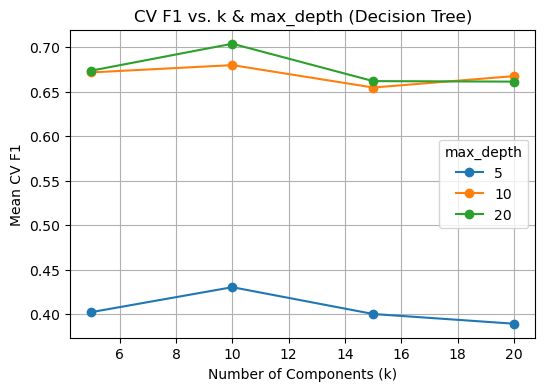

Permutation test p-value (DT): 0.009900990099009901
Bootstrap F1 95% CI (DT): [0.798, 0.988]


In [ ]:
# %% [markdown]
# ## 6. Overfitting & Robustness Checks (Decision Tree)

# %%
# 6a) Fit grid_dt once to inspect CV results
grid_dt.fit(X_arr, y)
results_dt = pd.DataFrame(grid_dt.cv_results_)

# extract k from the dicts
results_dt['k'] = results_dt['param_pca__kw_args'].apply(lambda d: d['k'])

# now group by (k, max_depth) and average the mean_test_score across min_samples_leaf
pivot_dt = (
    results_dt
      .groupby(['k', 'param_clf__max_depth'])['mean_test_score']
      .mean()
      .unstack('param_clf__max_depth')
)

# plot
pivot_dt.plot(marker='o', figsize=(6,4))
plt.xlabel("Number of Components (k)")
plt.ylabel("Mean CV F1")
plt.title("CV F1 vs. k & max_depth (Decision Tree)")
plt.legend(title='max_depth')
plt.grid(True)
plt.show()


# 6b) Permutation test on the best decision‐tree estimator
from sklearn.model_selection import permutation_test_score

best_dt = grid_dt.best_estimator_
score, perm_scores, pval = permutation_test_score(
    best_dt, X_arr, y, 
    cv=outer_cv, 
    n_permutations=100, 
    scoring='f1_macro',
    n_jobs=-1
)
print("Permutation test p-value (DT):", pval)

# 6c) Bootstrap 95% CI on F1
from sklearn.metrics import f1_score
from sklearn.utils import resample

boot_scores = []
for i in range(100):
    idx = resample(np.arange(len(X_arr)), replace=True, random_state=i)
    Xi, yi = X_arr[idx], y[idx]
    pred = best_dt.predict(Xi)
    boot_scores.append(f1_score(yi, pred, average='macro'))
ci_lower, ci_upper = np.percentile(boot_scores, [2.5, 97.5])
print(f"Bootstrap F1 95% CI (DT): [{ci_lower:.3f}, {ci_upper:.3f}]")


In [ ]:
# %% [markdown]
# ## 1d. Direct Comparison: Full vs Variance‐Threshold vs PCA‐DT (Precomputed PCA)

# %%
import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# --- Assumes X_imputed, y, eig_vecs, and grid_dt.best_params_ are defined ---

# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

# 2) Baseline full‐feature DT pipeline
pipe_full = Pipeline([
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=0))
])
t0 = time.time()
pipe_full.fit(X_train, y_train)
train_full = time.time() - t0
t1 = time.time()
pred_full = pipe_full.predict(X_test)
pred_full_time = time.time() - t1
f1_full = f1_score(y_test, pred_full, average='macro')

# 3) VarianceThreshold DT pipeline
pipe_vt = Pipeline([
    ('scale', StandardScaler()),
    ('vt', VarianceThreshold(threshold=0.01)),
    ('clf', DecisionTreeClassifier(random_state=0))
])
t0 = time.time()
pipe_vt.fit(X_train, y_train)
train_vt = time.time() - t0
t1 = time.time()
pred_vt = pipe_vt.predict(X_test)
pred_vt_time = time.time() - t1
f1_vt = f1_score(y_test, pred_vt, average='macro')

# 4) Precompute manual PCA projections once
best_params = grid_dt.best_params_
best_k = best_params['pca__kw_args']['k']
best_depth = best_params['clf__max_depth']
best_leaf  = best_params['clf__min_samples_leaf']

# a) scale data once
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# b) manual PCA transform function
def manual_pca_transform(X, k):
    Xc = X - X.mean(axis=0)
    return Xc.dot(eig_vecs[:, :k])

# c) apply transform
X_train_pca = manual_pca_transform(X_train_scaled, best_k)
X_test_pca  = manual_pca_transform(X_test_scaled,  best_k)

# 5) Train & time only the DT on PCA features
dt = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    random_state=0
)
t0 = time.time()
dt.fit(X_train_pca, y_train)
train_pca = time.time() - t0
t1 = time.time()
pred_pca = dt.predict(X_test_pca)
pred_pca_time = time.time() - t1
f1_pca = f1_score(y_test, pred_pca, average='macro')

# 6) Compile results into DataFrame
results_compare = pd.DataFrame([
    {
        'method': 'Decision Tree (full)',
        'n_features': X_imputed.shape[1],
        'train_time_s': train_full,
        'predict_time_s': pred_full_time,
        'f1_macro': f1_full
    },
    {
        'method': 'Decision Tree (variance threshold)',
        'n_features': pipe_vt.named_steps['vt'].transform(X_train).shape[1],
        'train_time_s': train_vt,
        'predict_time_s': pred_vt_time,
        'f1_macro': f1_vt
    },
    {
        'method': f'DT (PCA k={best_k})',
        'n_features': best_k,
        'train_time_s': train_pca,
        'predict_time_s': pred_pca_time,
        'f1_macro': f1_pca
    }
])
results_compare.set_index('method', inplace=True)
results_compare


/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


,n_features,train_time_s,predict_time_s,f1_macro
method,,,,
Decision Tree (full),22,0.024651,0.002952,0.928205
Decision Tree (variance threshold),22,0.025531,0.002950,0.928205
DT (PCA k=10),10,0.040996,0.000427,0.889454


In [ ]:
# %% [markdown]
# ## 2. RFE & Feature Agglomeration Benchmarks (Decision Tree)

# %%
import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# --- Assumes X_train, X_test, y_train, y_test are already defined ---

# 2a) RFE pipeline: use a random forest to select top-8 features, then DT
rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=0),
    n_features_to_select=8,
    step=1
)
pipe_rfe = Pipeline([
    ('scale', StandardScaler()),
    ('rfe', rfe_selector),
    ('clf', DecisionTreeClassifier(random_state=0))
])

t0 = time.time()
pipe_rfe.fit(X_train, y_train)
train_rfe = time.time() - t0
t1 = time.time()
y_pred_rfe = pipe_rfe.predict(X_test)
pred_rfe = time.time() - t1
f1_rfe = f1_score(y_test, y_pred_rfe, average='macro')

# 2b) Feature-Agglomeration pipeline: cluster into 20 meta-features, then DT
from sklearn.cluster import FeatureAgglomeration

agglo = FeatureAgglomeration(n_clusters=20)    # only n_clusters needed
pipe_agglo = Pipeline([
    ('scale', StandardScaler()),
    ('agglo', agglo),
    ('clf', DecisionTreeClassifier(random_state=0))
])

t0 = time.time()
pipe_agglo.fit(X_train, y_train)
train_agglo = time.time() - t0
t1 = time.time()
y_pred_agglo = pipe_agglo.predict(X_test)
pred_agglo = time.time() - t1
f1_agglo = f1_score(y_test, y_pred_agglo, average='macro')

# 2c) Compile RFE & Agglo results alongside your previous comparisons
extra_results = pd.DataFrame([
    {
        'method': 'DT (RFE → top-8)',
        'n_features': 8,
        'train_time_s': train_rfe,
        'predict_time_s': pred_rfe,
        'f1_macro': f1_rfe
    },
    {
        'method': 'DT (Agglomeration k=20)',
        'n_features': 20,
        'train_time_s': train_agglo,
        'predict_time_s': pred_agglo,
        'f1_macro': f1_agglo
    }
])

# append to your previous results_compare
final_comparison = pd.concat([results_compare, extra_results.set_index('method')])
final_comparison


,n_features,train_time_s,predict_time_s,f1_macro
method,,,,
Decision Tree (full),22,0.024651,0.002952,0.928205
Decision Tree (variance threshold),22,0.025531,0.002950,0.928205
DT (PCA k=10),10,0.040996,0.000427,0.889454
DT (RFE → top-8),8,5.998956,0.003503,0.817679
DT (Agglomeration k=20),20,0.035056,0.005692,0.926283


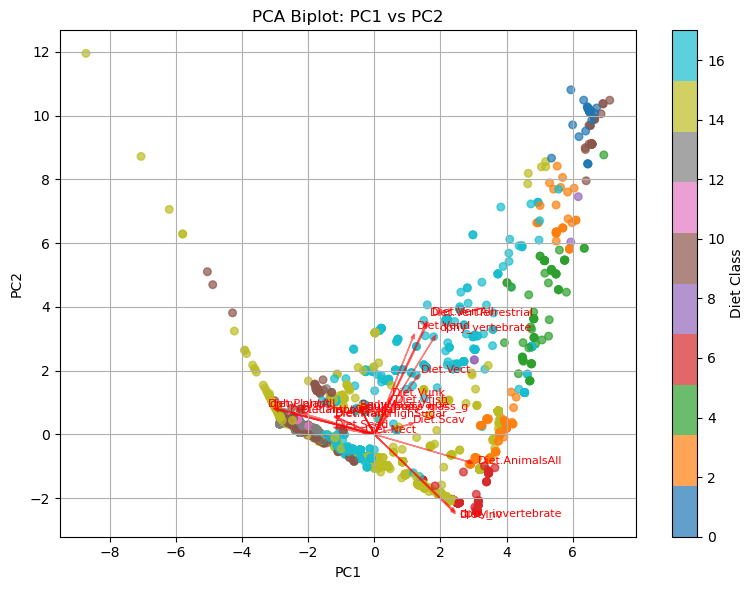

In [ ]:
# %% [markdown]
# ## 8. Visualization & Interpretation

# %% 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

# Assumes:
# - df_pca: DataFrame with PC1…PCk, index aligned with X_imputed.index
# - loadings: DataFrame of shape (n_features, k) with columns PC1…PCk
# - y: integer‐encoded target array
# - X_train_scaled, X_test_scaled, X_train_pca, X_test_pca defined earlier
# - eig_vecs, X_scaled, X_centered defined from your manual PCA steps

### 8a) PCA biplot of PC1 vs PC2 ###
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df_pca['PC1'], df_pca['PC2'],
    c=y, cmap='tab10', alpha=0.7, s=30
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot: PC1 vs PC2')
plt.colorbar(scatter, label='Diet Class')

# scale arrows so they fit on the same axes
scale = 3 * max(df_pca['PC1'].std(), df_pca['PC2'].std())
for feat, vec in loadings[['PC1','PC2']].iterrows():
    plt.arrow(0, 0, vec['PC1']*scale, vec['PC2']*scale,
              color='red', alpha=0.5, head_width=0.1)
    plt.text(vec['PC1']*scale*1.1, vec['PC2']*scale*1.1,
             feat, color='red', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/jupyter-deu225/.conda/envs/DSCI-498-main/lib/python3.12/site-packages/sklearn/model_se

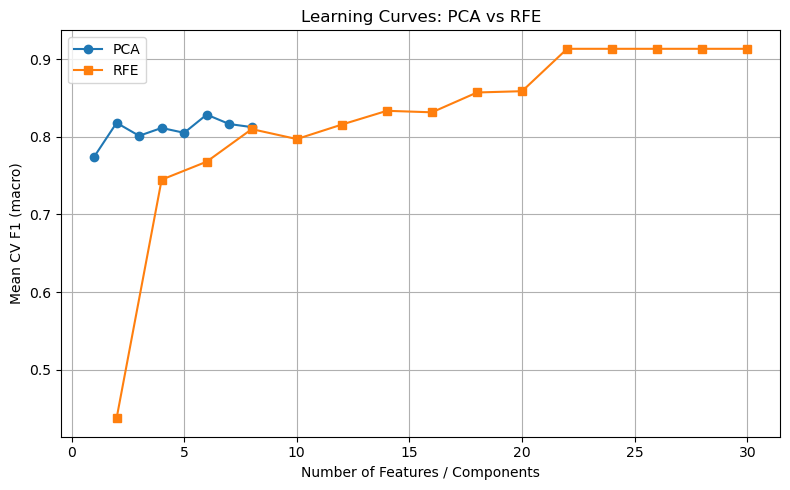

In [ ]:
### 8b) Learning curves: CV F1 vs #PCs and vs #RFE‐features ###
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# PCA curve
max_k = df_pca.shape[1]
ks = list(range(1, max_k+1))
pca_f1 = []
for k in ks:
    # project to k PCs
    Xk = X_centered.dot(eig_vecs[:, :k])
    scores = cross_val_score(
        DecisionTreeClassifier(random_state=0),
        Xk, y, cv=cv, scoring='f1_macro', n_jobs=-1
    )
    pca_f1.append(scores.mean())

# RFE curve
rfe_feats = list(range(2, 31, 2))  # e.g. 2,4,...30
rfe_f1 = []
for n in rfe_feats:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('rfe', RFE(RandomForestClassifier(n_estimators=100, random_state=0),
                    n_features_to_select=n, step=1)),
        ('clf', DecisionTreeClassifier(random_state=0))
    ])
    scores = cross_val_score(pipe, X_imputed, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    rfe_f1.append(scores.mean())

plt.figure(figsize=(8,5))
plt.plot(ks, pca_f1, marker='o', label='PCA')
plt.plot(rfe_feats, rfe_f1, marker='s', label='RFE')
plt.xlabel('Number of Features / Components')
plt.ylabel('Mean CV F1 (macro)')
plt.title('Learning Curves: PCA vs RFE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

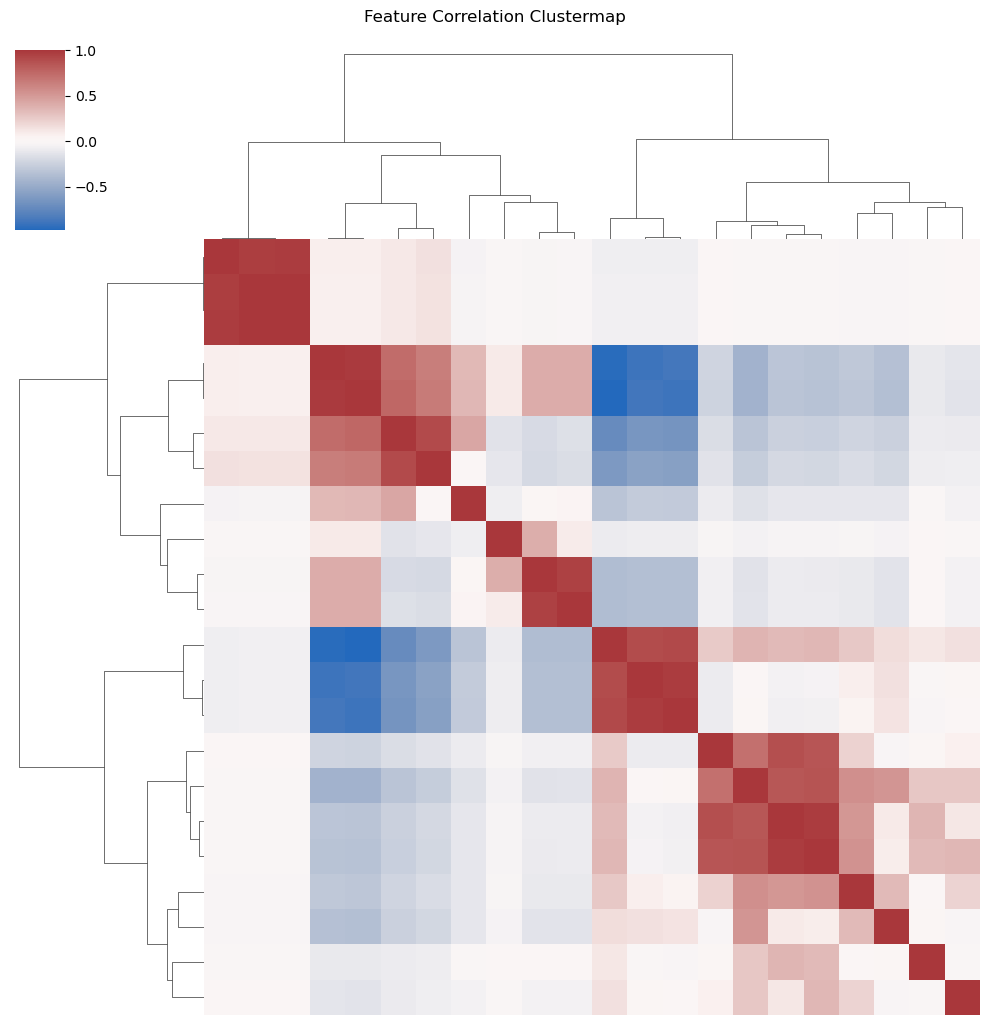

In [ ]:
### 8c) Correlation heatmap + dendrogram ###
num_df = master_all_final.select_dtypes(include='number')
corr = num_df.corr()

sns.clustermap(
    corr, 
    method='ward',      # hierarchical clustering linkage
    metric='euclidean',
    cmap='vlag',
    yticklabels=False,
    xticklabels=False
)
plt.suptitle('Feature Correlation Clustermap', y=1.02)
plt.show()